## DS807: Applied machine learning
Christian M. Dahl. cmd@sam.sdu.dk.

### Autoencoders

Notes: For the purpose of this notebook, DLWP refers to Deep Learning with Python by Francois Collet (ISBN10: 9781617294433).

## Introduction

*Autoencoders* (AE) are a type of neural network which may be described as *encoding* information (data) into a *latent representation* and then *decoding* this information back into its original form.

This sounds rather vague, but I think it is difficult to phrase it differently without missing out on some of the possibilities of AEs. Their uses include:
1. Data compression.
1. Feature construction.
1. Image denoising and super-resolution.
1. Anomaly detection.
1. Generate realistic artificial data.
1. ... and much more. Indeed, it is likely not fully understood what they are capable of yet. Perhaps one of you will come up with something entirely new to use them for!

An important extension of AEs is *variational* autoencoders (VAE). Much of the impressive work done by AEs are specifically due to VAEs. They add a stochastic element into AEs. Instead of encoding the input to a fixed code, they encode it to the parameters of a statistical distribution. This is helpful as it improves robustness and forces the latent space to encode meaningful representations everywhere. 

## Program

After this lecture, you will:

1. Know what an autoencoder is, how to train/use it and in which scenarios you may want to use autoencoders.
1. Know what a variational autoencoder is, and how it helps solve problems "normal" autoencoders struggle with.
1. Know of the reparameterization trick is, and how it makes backpropagation possible.
1. Have applied your knowledge in order to train autoencoders to perform anomaly detection, image denoising, and generate artificial data.

## Unsupervised (self-supervised) learning

Most of what we have done throughout this course is *supervised* learning. Supervised learning is solving a problem by presenting the "correct answer" to the algorithm, i.e. providing features and targets/labels and letting the algorithm learn to predict the correct target/label based on features.

Unsupervised learning is broadly everything where we *do not* provide the "correct answer" to the algorithm.

Crucially, this does not mean we do not provide *any* answer to the algorithm - we still need something to optimize. However, this thing is now *auxiliary*, i.e. we are interested in it insofar it helps us solve our primary objective.

One example of this is spatial transformers. We never provided even one example of the best spatial transformation to apply to any image, but by learning to perform classification this was learned "on the side". Here, the classification part was learned in a supervised way, but the image transformation part was learned in an unsupervised way.

Other examples of unsupervised learning you likely are familiar with include principal component analysis (PCA) and clustering.

## What is an autoencoder?

An autoencoder is a neural network that uses the *same* data for both its inputs and outputs (i.e. the $x$ and $y$ side of the equation). This does not immediately seem very useful, but a crucial feature is that the network will at some point include was it often referred to as a *bottleneck layer*. This is a layer that has relatively few neurons (compared to the number of variables). For example, if you have 20 variables you might want to use a bottleneck layer with 5 neurons.

To summarize, this means that there are two required parts of an autoencoder:
1. It uses the same data as its inputs and outputs, aiming to *recreate* the input as its outputs (this is not strictly true, as we will see shortly).
1. It uses a *bottleneck layer* somewhere to *compress* the information of the features.

Typically, the part of the autoencoder before the *bottleneck layer* is referred to as the *encoder* and the part of the autoencoder after the *bottleneck layer* is referred to as the *decoder*.

Autoencoders are due to "Kramer, M. A. (1991). Nonlinear principal component analysis using autoassociative neural networks. AIChE journal, 37(2), 233-243".

### An autoencoder consists of an encoder (G) and a decoder (H)

<img src="./graphics/kramer-1991-fig-2.png" alt="Drawing" style="width: 600px;"/>

Source: "Kramer, M. A. (1991). Nonlinear principal component analysis using autoassociative neural networks. AIChE journal, 37(2), 233-243"

### Autoencoder architecture for images
<img src="./graphics/98612autoencoder.JPG" alt="Drawing" style="width: 1000px;"/>

## A simple autoencoder in TensorFlow

... with 20 input features and a bottleneck layer with 5 neurons.

In [4]:
import tensorflow as tf

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=(20,), activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'), # this is the bottleneck layer
], name='encoder')

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=(5,), activation='relu'), 
    # 5 since we compress features into 5 neurons
    tf.keras.layers.Dense(20), 
    # map back to 20 as we have 20 features and want to reconstruct these
], name='decoder')

autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

In [5]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 5)                 785       
                                                                 
 decoder (Sequential)        (None, 20)                800       
                                                                 
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________


In [3]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                630       
                                                                 
 dense_1 (Dense)             (None, 5)                 155       
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 30)                180       
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
Total params: 800
Trainable params: 800
Non-

## What makes autoencoders unsupervised (self-supervised)?

We train autoencoders in much the same way as we train any other model, i.e. we provide both $x$ and $y$ - they just happen to be the same.

However, crucially to note is that we are never actually interested in the "perfect reconstruction" of the inputs - we already have the correct values (i.e. the $x$ side of the equation). Learning the perfect reconstruction functions amounts to learning a functions such that

$\hat{x} = H(G(x))$

where G is the encoder and H is the decoder. This is not very interesting as a whole.

However, as part of learning this function, we learn a very interesting part - namely $G$. This is taught to *compress* the data (provided the bottleneck layer is sufficiently small) as effectively as possible (which means in a way to reduce the reconstruction error as much as possible).

We never provide any examples of *how* this *compressed representation* should look, but it is still learned. That is, learning the *compressed representation* is an unsupervised problem.

## We learn the *compressed representation*, without any labels of these!

<img src="./graphics/figure_8-12.png" alt="Drawing" style="width: 1000px;"/>
Source: "DLWP"

## Why is the "compressed" representation useful?

We need to ask ourselves if we have actually learned something useful - in this case whether the latent$^1$ representation is useful. 

To understand why this is useful, think of the following benefits:
1. The latent representation is smaller (i.e. compressed). If the reconstruction is good, this may allow us to store data more effeciently.
1. The latent representation contains less redundant information, which may mean that it provides better features (i.e. this is a form of feature engineering)$^2$.
1. The latent representation may discard "irrelevant" information, such as noise on images. This can be used for image denoising$^3$.
1. The reconstruction might prove difficult for anomalies; this can be used to detect anomalies in your data (failues of systems, fraud, and such).

$^1$Often the compressed representation is called the latent representation.
<br>
$^2$This is closely related to what you may be familiar with from PCA. However, in PCA a linear transformation is applied whereas the transformation of an autoencoder may be non-linear.
<br>
$^3$In these cases, autoencoders are typically supervised (i.e. we are now interested in a reconstruction that *differs* from the input and we often have targets/labels of these).

## PCA

<img src="./graphics/Algebraic+definition+of+PCA.jpg" alt="Drawing" style="width: 1000px;"/>

## PCA by an autoencoder

.. with **only** linear layers!

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

features, targets = load_breast_cancer(return_X_y=True)
print(features.shape, targets.shape)

scaler = StandardScaler()
features = scaler.fit_transform(features)

(569, 30) (569,)


In [6]:
pca = PCA(n_components=5)
pca.fit(features)
features_pca = pca.transform(features) # Equivalent to the predict function

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(30,),),
    tf.keras.layers.Dense(64,),
    tf.keras.layers.Dense(32,),
    tf.keras.layers.Dense(5,),
], name='encoder')

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(246, input_shape=(5,), ),
    tf.keras.layers.Dense(128, ),
    tf.keras.layers.Dense(64, ),
    tf.keras.layers.Dense(30),
], name='decoder')

autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(loss='mse', optimizer='adam')
#autoencoder.summary()

autoencoder.fit(features, features, epochs=1000, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss')], verbose=0)
features_ae = encoder.predict(features)

18/18 [==============================] - 0s 1ms/step


## Even though the two "latent representations" have the same shape, they are *not* directly comparable!

In [11]:
print(features_pca.shape)
print(features_ae.shape)

delta_latent = np.mean(np.square(features_pca - features_ae))
print(f'Naïvely comparing the two "latent representations" leads to a high \n MSE of {round(delta_latent, 2)}. So they are quite different.')

(569, 5)
(569, 5)
Naïvely comparing the two "latent representations" leads to a high 
 MSE of 5.68. So they are quite different.


This is due to the fact that while PCA attempts to explain as much variance as possible in the first component, then as much as possible in the second under the conditional of orthogonality to the first and so forth, this is not a restriction we place on the autoencoder.

However, to show that they accomplish the same thing, let as now try to reconstruct the original features using the latent representations. These will be *very* similar.

## Reconstruction

In [16]:
reconstruction_pca = pca.inverse_transform(features_pca)
reconstruction_ae = decoder.predict(features_ae)

delta_reconstruction = np.mean(np.square(reconstruction_pca 
                                         - reconstruction_ae))

print(f'The reconstructions are very close with a low 
      mean squared error of {round(delta_reconstruction, 3)}')



 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
The reconstructions are very close with a low mean squared error of 0.074


In [18]:
mse_reconstruction_pca = np.mean(np.square(reconstruction_pca
                                            - features))
mse_reconstruction_ae = np.mean(np.square(reconstruction_ae 
                                          - features))

print(f'\nFurther, they are quite close to the original features, 
      with the following mean squared errors:')
print(f'\t1) PCA reconstruction MSE = {round(mse_reconstruction_pca, 3)}')
print(f'\t2) AE reconstruction MSE = {round(mse_reconstruction_ae, 3)}')


Further, they are quite close to the original features, with the following mean squared errors:
	1) PCA reconstruction MSE = 0.153
	2) AE reconstruction MSE = 0.199


## Nonlinear AE - is it any better?

In [22]:
encoder_nl = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(30,),activation='relu',),
    tf.keras.layers.Dense(64,activation='relu',),
    tf.keras.layers.Dense(32,activation='relu',),
    tf.keras.layers.Dense(5,),
], name='encoder')

decoder_nl = tf.keras.models.Sequential([
    tf.keras.layers.Dense(246, input_shape=(5,),activation='relu', ),
    tf.keras.layers.Dense(128, activation='relu',),
    tf.keras.layers.Dense(64, activation='relu',),
    tf.keras.layers.Dense(30,),
], name='decoder')

autoencoder_nl = tf.keras.models.Sequential([encoder_nl, decoder_nl], name='autoencoder')
autoencoder_nl.compile(loss='mse', optimizer='adam')
#autoencoder_nl.summary()

autoencoder_nl.fit(features, features, epochs=10000, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss')], verbose=0)
features_ae_nl = encoder_nl.predict(features)

18/18 [==============================] - 0s 1ms/step


### The reconstruction error is now higher!?

In [26]:
reconstruction_ae_nl = decoder_nl.predict(features_ae_nl)
mse_reconstruction_ae_nl = np.mean(np.square(reconstruction_ae_nl - features))

print(f'\nMean squared error of reconstructions:')
print(f'\t1) PCA recon MSE = {round(mse_reconstruction_pca, 3)}')
print(f'\t2) AE (linear) recon MSE = {round(mse_reconstruction_ae, 3)}')
print(f'\t2) AE (nonlinear) recon MSE = {round(mse_reconstruction_ae_nl, 3)}')

 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step

Mean squared error of reconstructions:
	1) PCA recon MSE = 0.153
	2) AE (linear) recon MSE = 0.199
	2) AE (nonlinear) recon MSE = 0.443


...whether the autoencoder is "better" is much more difficult to answer - it depends on the task you want it to solve.

If your goal is to use these latent representations as new features, you need to try them out and see what is best. This will also depend on the model you use.

Further, nonlinear AEs, especially if they are large, are prone to overfitting, so using a validation/test set to track the performance is recommended.

## Anomaly detection

To understand why autoencoders are able to detect anomalies, imagine you train an autoencoder on a lot of "normal" samples, i.e. non-anomalies.

If you do a good job, the reconstruction error on any sample should be relatively small, since your reconstructions will be good.

However, if you then all of a sudden try to encode and decode an *outlier* or *anomaly*, your model may no longer do a good job. As such, the reconstruction error of this sample might be very high.

Imagine you have calculated all the reconstruction losses on your "normal" samples. Then, you can try to detect outliers by seeing if the reconstruction loss of a sample is higher than is expected. If this is the case, the observation is likely an outlier/anomaly. 

Let us do this in a very simple context: the circles dataset (from our very first lecture). This is very illustrative, since there are only 2 features (which we will then encode into one feature).

## The data

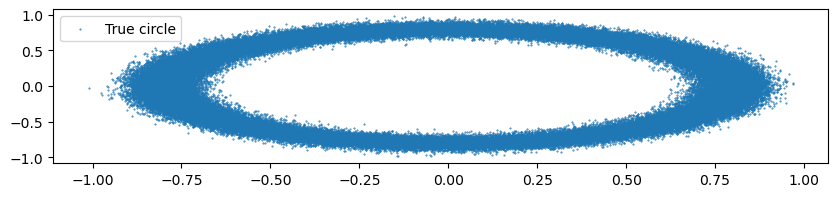

In [35]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt

x, y = make_circles(n_samples=200000, noise=0.05)
inner_circle = x[y == 1] # Only interested in one of the circles

plt.figure(figsize=(10, 2))
plt.scatter(inner_circle[:, 0], inner_circle[:, 1], 
            label='True circle', s=0.2)
plt.legend(); plt.grid; plt.show()

## Autoencoding

We can use an autoencoder to encode the data. 

In [36]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')], name='encoder')
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(1,), activation='relu'),
    tf.keras.layers.Dense(2)], name='decoder')
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(loss='mse', optimizer='adam')
#autoencoder.summary()

autoencoder.fit(inner_circle, inner_circle, epochs=2000, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss')], verbose=0);

## Reconstruction errors

Finally, let us calculate the reconstruction errors for the autoencoder.

In [37]:
features_ae = encoder.predict(inner_circle)
reconstruction_ae = decoder.predict(features_ae)

reconstruction_losses_ae = np.mean(np.square(reconstruction_ae - inner_circle), axis=1)

print(f'Reconstruction MSE AE = {round(np.mean(reconstruction_losses_ae), 3)}')

   1/3125 [..............................] - ETA: 2:04

3125/3125 [==============================] - 4s 1ms/step
Reconstruction MSE AE = 0.02


## Illustrating the reconstructions

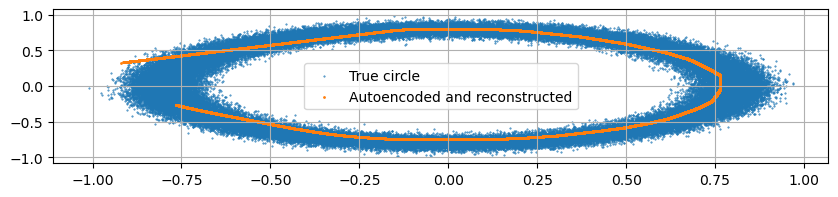

In [38]:
plt.figure(figsize=(10, 2))
plt.scatter(inner_circle[:, 0], inner_circle[:, 1], label='True circle', s=0.2)
plt.scatter(reconstruction_ae[:, 0], reconstruction_ae[:, 1], label='Autoencoded and reconstructed', s=1)
plt.legend(); plt.grid(); plt.show()

## Outliers/anomalies

Now, let us add some anomalies. I will just define some by hand. They are very easy to see just looking at the data, but this is only because the example is so simple.

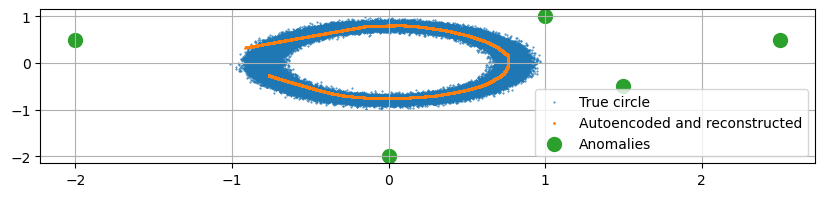

In [39]:
anomalies = np.array([[2.5, 0.5], [1, 1], [-2, 0.5], [1.5, -0.5], [0, -2]])

plt.figure(figsize=(10, 2))
plt.scatter(inner_circle[:, 0], inner_circle[:, 1], label='True circle', s=0.2)
plt.scatter(reconstruction_ae[:, 0], reconstruction_ae[:, 1], label='Autoencoded and reconstructed', s=1)
plt.scatter(anomalies[:, 0], anomalies[:, 1], label='Anomalies', s=100)
plt.legend(); plt.grid(); plt.show()

## Identifying the outliers

Now, let us use our autoencoder and our optimal encoding to see if we can "find" the outliers.

Since our autoencoder isn't perfect, let us use as the threshold for the reconstruction loss the 98.5% highest loss in the valid data (this allows for 1.5% of the training observations to have been reconstructed poorly - however, it means we can expect to wrongly classify 1.5% of valid data as anomalies).

For our "optimal" encoding, we set the threshold as the highest loss in the valid data (as it makes no bad mistakes).

## Autoencoder for anomaly detection

In [49]:
reconstructed_anomalies_ae = autoencoder.predict(anomalies)
reconstruction_losses_anomalies_ae = np.mean(np.square(anomalies - reconstructed_anomalies_ae), axis=1)

threshold_ae = np.quantile(reconstruction_losses_ae, 0.975)
print(f'{sum(reconstruction_losses_anomalies_ae >= threshold_ae)} of {len(anomalies)} detected.')

1/1 [==============================] - 0s 16ms/step
5 of 5 detected.


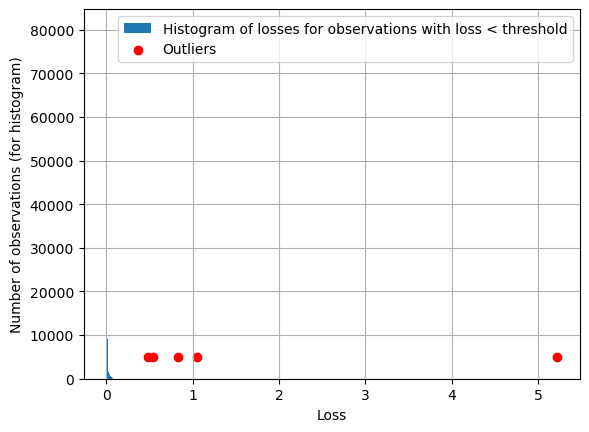

In [51]:
plt.hist(reconstruction_losses_ae[reconstruction_losses_ae < threshold_ae], 
         label='Histogram of losses for observations with loss < threshold')
plt.scatter(reconstruction_losses_anomalies_ae, [5000] * len(anomalies), 
            c='red', label='Outliers')
plt.xlabel('Loss'); plt.ylabel('Number of observations (for histogram)')
plt.legend(); plt.grid(); plt.show()

## When is this method of anomaly detection useful?

Some of you may ask: Why not solve anomaly detection in a supervised fashion by training a network to perform binary classification (normal vs. anomalous data)?

There are two (very related) reasons we may not be able to solve the problem in a supervised fashion:
1. We may have too few examples of anomalies for our supervised network to perform well.
1. We may not even know which examples are anomalies. This is also a problem for autoencoders, but they may still be able to learn to detect them, provided there are sufficiently few anomalies. In such cases, we hope for the autoencoder to learn to encode and decode normal data but not have enough capacity to learn to encode and decode the anomalies.

In the first case, it is often worthwhile to *attempt* to solve the problem in a supervised fashion (and then use whatever is best of the supervised vs. unsupervised approach, perhaps even combining the two), but in the second case it is not even possible!

### Exercise

Use the $\texttt{ECG5000}$ dataset$^1$ to perform autoencoding and anomaly detection of ECGs. Specifically, split the data into normal and anomalous data as well as a train and test set. 

1. Use a linear and a nonlinear autoencoder to perform reconstructions of the **normal** ECGs. Measure performance both by MSE and MAE. Which model is best on the respective measures (measured on the test data, having used the train data to train the models)? The bottleneck layer should contain 8 neurons.
1. Use one or both of the models from above to perform anomaly detection (you decide which metric, i.e. MSE or MAE, to use for this purpose). That is, find the losses on the training data, and then decide on a threshold above which you classify data as anomolous.
1. Use a supervised model to perform anomaly detection (i.e. use both the normal and anomolous data for training). Is this model better than the approach above? Is this still the case if you restrict the number of anomalies in the training data to a small number (such as 10)?

$^1$http://www.timeseriesclassification.com/description.php?Dataset=ECG5000.
<br>
**Note**: This exercise is based on https://www.tensorflow.org/tutorials/generative/autoencoder.
<br>
**Hint**: You may use **exercise-ae-anomalies.ipynb** as a start

## Data reconstruction for images and understanding the latent space

Now that we know the basics and have applied it for outlier detection, let us consider reconstruction of images. This is very common in the literature, and also highly useful in practice in cases such as image denoising and super resolution.

Further, it is illustrative - we can actually see what it going on. This is especially useful to understand the latent space.

When working with images, unsurprisingly convolutional layers are useful. However, you may ask how we go *from* the bottleneck layer to the original size again. Here, we will use what is called *transposed convolutions* (or deconvolutions), which can be thought of as going "the other way" with respect to image size.

See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose.

## Autoencoder architecture for images
<img src="./graphics/98612autoencoder.JPG" alt="Drawing" style="width: 1000px;"/>

## Transposed convolutions

<img src="./graphics/CONV2DTranspose.gif" alt="Drawing" style="width: 1000px;"/>

 #### A Conv2DTranspose applying a 3x3 kernel to a 4x4 input to give a 6x6 output

## Transposed convolutions

The model below first applies a 3x3 convolution, shrinking image size from 28x28 to 26x26. Then, it is scaled up using a transposed convolution.

In [52]:
conv_transposeconv_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=1),
])

conv_transposeconv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 1)        289       
 nspose)                                                         
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


## Simple reconstruction using Fashion MNIST

This is inspired by https://www.tensorflow.org/tutorials/generative/autoencoder.

In [54]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = 
            tf.keras.datasets.fashion_mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255

x_train = x_train.reshape((*x_train.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

In [55]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=(3, 3),activation='relu',padding='same',strides=2,input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
],name='encoder')

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(8,3,strides=2,activation='relu',padding='same',input_shape=(7, 7, 8)),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
],name='decoder')

In [56]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 7, 7, 8)           1320      
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [61]:
autoencoder.fit(x_train, x_train, 
                validation_data=(x_test, x_test),epochs=10,
                verbose=0)

In [58]:
x_test_encoded = encoder.predict(x_test)
print(x_test_encoded.shape)
x_test_decoded = decoder.predict(x_test_encoded)
print(x_test_decoded.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 7, 7, 8)
313/313 [==============================] - 0s 1ms/step
(10000, 28, 28, 1)


In [62]:
def plot(n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i][:, :, 0])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_decoded[i][:, :, 0])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Original and reconstructed images

The reconstructions are quite good, but the latent space is also relatively large compared to the entire space (7x7x8=392 vs. 28x28=784 numbers pr. image).

**Suggestion**: Try to replicate this example, but with a smaller latent space. This can be accomplished quite simply by reducing the number of filters in the bottleneck layer from 8 to a smaller number. Note that you must also change the input shape of the decoder in this case.

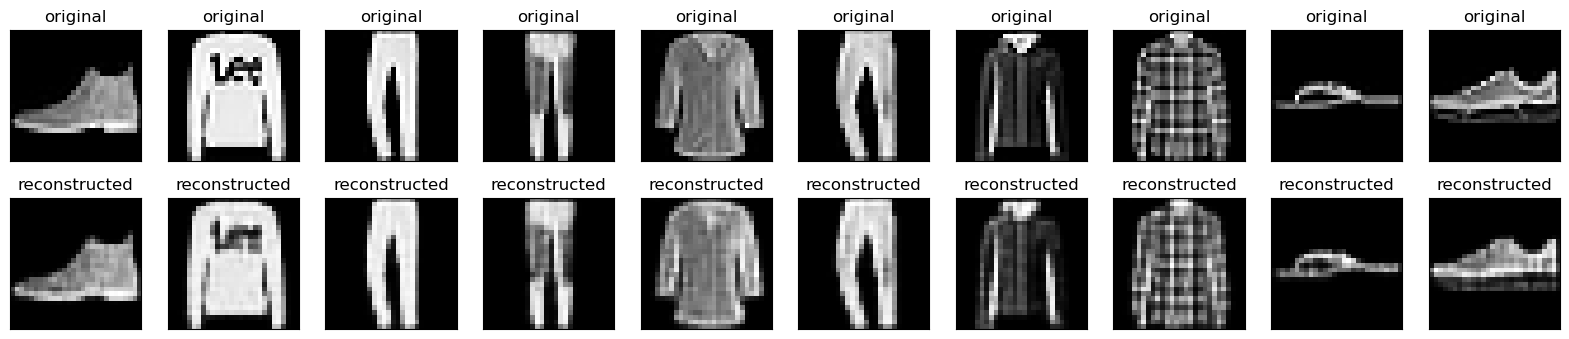

In [63]:
plot(10)

## Exercises

Use the Fashion MNIST data to solve this exercise. Load the images. Then, create a version of the images where artificial noise is added. Your main objective is to remove this noise.

1. Using an autoencoder where the input is the noisy images and the output is the original images, attempt to remove the noise. Note how this is essentially a supervised task.
1. Suppose you only longer have access to original images (i.e. without noise) for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the *noisy* test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.
1. Suppose you no longer have access to original images (i.e. without noise) but only the noisy images for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the noisy test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.

**Hint**: You may use the notebook I have uploaded under this lecture as a starting point (exercise-ae-denoising.ipynb). It provides some of the code, and you then have to fill in the rest. You do not have to use it - it is there if you think it might be helpful!

<img src="./graphics/Ttitlepage.PNG" alt="Drawing" style="width: 1000px;"/>

[Link to paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjj9au2_Nj0AhVrRPEDHbDsBX4QFnoECAQQAQ&url=https%3A%2F%2Fusers.wpi.edu%2F~yli15%2FIncludes%2FAdvML20_Huimin.pdf&usg=AOvVaw0kzHOgAFhcnkjz_nyBxGnu)

<img src="./graphics/Noisereductionexamples.PNG" alt="Drawing" style="width: 800px;"/>

## Diving into the latent space and motivating variational autoencoders

We can "move" in the latent space we create by autoencoding our images.

If we have created a meaningful latent space, this might produce interesting results, i.e. generate new, realistic images.

However, as will become apparent this is not the case. This is a weakness of standard autoencoders and a problem variational autoencoders aim to solve.



To showcase the problem, let us pick a **shoe** and a pair of **pants** and try to gradually move the latent representation from the shoe to the pants, while we plot the reconstructions as we go along.

In [64]:
latent_space = np.linspace(x_test_encoded[0], x_test_encoded[2], 20)
print(x_test_encoded[0].shape)
print(x_test_encoded[2].shape)
print(latent_space.shape)
reconstructions = decoder.predict(latent_space)
print(reconstructions.shape)

(7, 7, 8)
(7, 7, 8)
(20, 7, 7, 8)
1/1 [==============================] - 0s 150ms/step
(20, 28, 28, 1)


## Decoding the latent representations of moving from the shoe to the pair of pants

Clearly the intermediate images are not particularly meaningful.

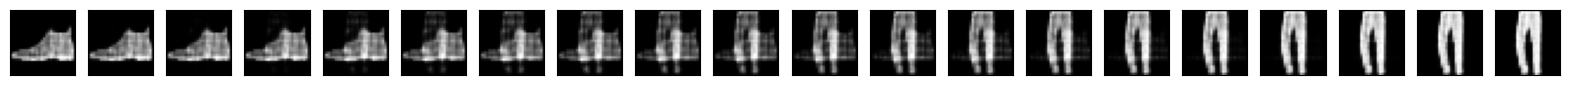

In [71]:
plt.figure(figsize=(20, 4))
for i in range(len(reconstructions)):
    ax = plt.subplot(1, len(reconstructions), i + 1)
    plt.imshow(reconstructions[i][:, :, 0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## "Average" pieces of cloths

Another potential way to look into the latent space is to investigate the average latents of different classes.

We could simply average the images of the different classes, but this often results in very blurry and not interesting images.

By calculating the latent representation for each image in a class, and then averages these and decoding, we might end up with more interesting images.

However, once again this is not in any way guaranteed, especially for "normal" autoencoders, as the latent space in general may not be particularly meaningful.

In [ ]:
avg_cloths = []
avg_decoded_latents = []

for i in range(10):
    x_test_sub = x_test[y_test == i]
    latent = encoder.predict(x_test_sub)
    avg_latent = np.mean(latent, axis=0)
    avg_cloths.append(np.mean(x_test_sub, axis=0))
    avg_decoded_latents.append(decoder.predict(avg_latent.reshape(1, *avg_latent.shape)))

In [73]:
def plot_averages():
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(avg_cloths[i][:, :, 0])
        plt.title("Mean of images")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(avg_decoded_latents[i][0, :, :, 0])
        plt.title("Decoded latents")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Mean of pixels for images (top) and decoded average latents (bottom)

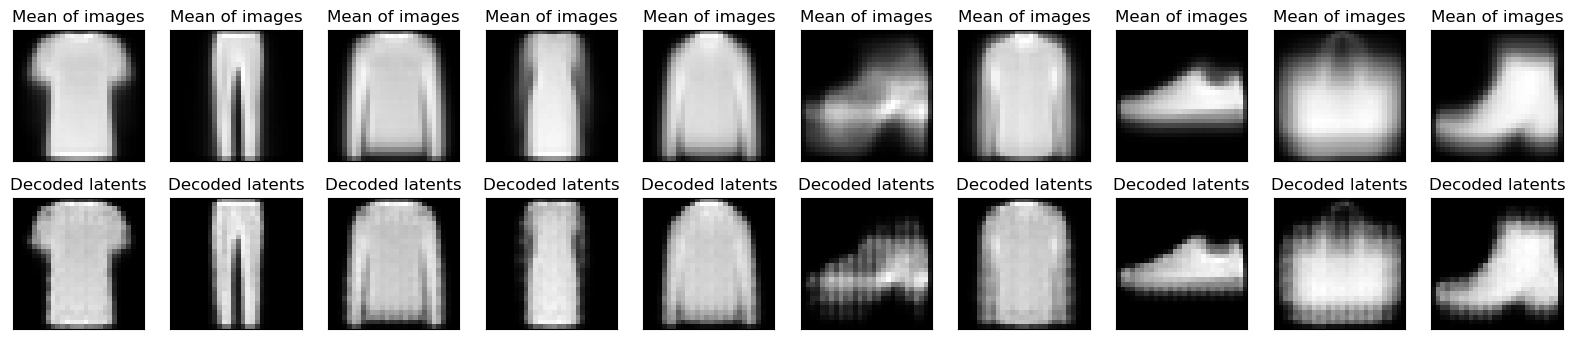

In [74]:
plot_averages()

## Structure of the latent space

The above examples illustrate quite clearly a weakness of "normal" autoencoders.

Although the individual latent representations are quite good, in that they allow for good reconstructions despite performing compression, the latent space is not in general very meaningful, and the moment we "move about" in it, there is no guarantee that the resulting decoded representations are meaningful.

Further, it is quite difficult to say in general what the different dimensions of the latent space represent.

This is some of the motivation behind *variational* autoencoders. Broadly speaking, instead of learning a latent space we now learn the parameters of a statistical distribution, which we then draw from and decode.

Sampling from a distribution is key, in that it forces every point to represent something meaningful.

## Variational autoencoders

Variational autoencoders are due to Kingma and Welling (2013) and Rezende, Mohamed, and Wierstra (2014) (simultaneously discovered). I will primarily focus on Kingma and Welling (2013) in this lecture.

VAEs augment the "normal" autoencoder by "adding an additional step". Specifically, now the encoder encodes *parameters of a stochastic distribution* (instead of a latent representation), a point is *sampled* from this distribution, and the decoder maps the *point* back to the input of the encoder.

That is, there is now an additional *sampling step*. This is crucial, primarily for two reasons:
1. It allows us to generate new, artificial (but realistic) data.
1. It allows us - to some extent - to control *how* we generate data (i.e. the contents of the data we generate).

<img src="./graphics/figure_8-13.png" alt="Drawing" style="width: 1000px;"/>
Source: "DLWP"

<img src="./graphics/VAEarchitecture.png" alt="Drawing" style="width: 1000px;"/>

## Artificial data generation

<img src="./graphics/figure_8-10.png" alt="Drawing" style="width: 1000px;"/>
Source: "DLWP"

## Controlling the contents - the "smile" vector

<img src="./graphics/figure_8-11.png" alt="Drawing" style="width: 1000px;"/>
Source: "DLWP"

## The fundamentals: Variational Bayes

We are interested in modelling - or learning - a distribution that generates the data we are working with ($p_{\theta}(x)$).

However, the posterior distribution may - and often is - intractable (involves integrals). This poses a challenge.

One approach to solve this issue is the **variational Bayesian** approach, which involves optimizing an (often much simpler) approximation to the "intractable" posterior. However, even this approach is not always immediately feasible.

Kingma and Welling (2013) approach the problem by:
1. Providing an **unbiased estimator** of the **variational lower bound**, which can be optimized by stochastic gradient descent.
1. Proposing the Auto-Encoding Variational Bayesian algorithm, by using the estimator above to optimize a **recognition model** (the encoder $q_{\phi}(z|x)$).
1. Inventing the **variational autoencoder**, which is the result of using a neural network as the **recognition model** in the algorithm above.

**Note**: The following is more technical than most of this course. It is mainly here for those of you interested in working in more details in this topic (such as during your thesis, graduate work, or so forth). We will get back to the applied part shortly!

## The directed graphical model considered

- Recall: $p_{\theta}(x|z)=p_{\theta}(x,z) / p_{\theta}(z) = p_{\theta}(z|x)p_{\theta}(x)/p_{\theta}(z) $
<br>
- Consequently: $p_{\theta}(x) =  p_{\theta}(z) p_{\theta}(x|z)  / p_{\theta}(z|x)$
<br>
<br>
- Generative model: $p_{\theta}(z)p_{\theta}(x|z)$ (bold lines)
<br>
- Goal: A variational approximation to the "intractable" posterior $p_{\theta}(z|x)$: $q_{\phi}(z|x)$ (dashed lines, recognition model)

<img src="./graphics/kingma-welling-14-fig-1.png" alt="Drawing" style="width: 200px;"/>

Source: "Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114"

## Statistical divergence

We are often interested in modelling a statistical distribution. This motivates the need for a measure of the "distance" between statistical distributions (such as the true distribution versus our estimate).

In such contexts, we use a divergence measure to measure this "distance" (note that divergence in general is not a proper distance, as it needs not be symmetric or satisfy the triangle inequality).

We have encountered (Kullback-Leibler) divergence throughout the course, in the form of cross entropy. Specifically

1. Kullback-Leibler divergence (relative free entropy): $D_{KL}(P||Q) = \Sigma_x P(x)log(\frac{P(x)}{Q(x)})$
1. Cross entropy: $H(P, Q) = -\Sigma_x P(x)log(Q(x))$ (how we use it in TensorFlow for 1 observation: $-y^T\,log(\hat{y})$)

which is "equivalent" for optimization purposes with respect to $Q$ since 
<br>
$D_{KL}(P||Q)=\Sigma_x P(x)log(P(x)) - \Sigma_x P(x) log(Q(x))$ 
<br>
where we can ignore the first term.

Another divergence measure (which is symmetric) would be the squared Euclidean distance (think of MSE).

## The variational lower bound$^1$

We are interested in optimizing the marginal likelihood over $N$ i.i.d. datapoints, i.e. $p_{\theta}(x^{(1)},...,x^{(N)})=\Pi_{i=1}^Np_{\theta}(x^{(i)})$.

As with almost any setting (think maximum likelihood), we approach this through the log-likelihood, i.e. $log\,p_{\theta}(x^{(1)},...,x^{(N)})=\Sigma_{i=1}^Nlog\,p_{\theta}(x^{(i)})$, with individual terms $log\,p_{\theta}(x^{(i)}) = D_{KL}[q_{\phi}(z|x^{(i)})||p_{\theta}(z|x^{(i)})] + \mathcal{L}(\theta,\phi;x^{(i)})$.

Since $D_{KL}[q_{\phi}(z|x^{(i)})||p_{\theta}(z|x^{(i)})]\geq0$ (divergence), $log\,p_{\theta}(x^{(i)})\geq\mathcal{L}(\theta,\phi;x^{(i)})$; hence the name of **variational** ***lower bound*** of the RHS (i.e. the marginal (log) likelihood is at least as great as the sum over $\mathcal{L}(\theta,\phi;x^{(i)})$). We want to optimize this lower bound, i.e.$\mathcal{L}(\theta,\phi;x^{(i)})=-D_{KL}[q_{\phi}(z|x^{(i)})||p_{\theta}(z)] + \mathbb{E}_{q_\phi(z|x^{(i)})}[log\,p_\theta(x^{(i)}|z)]$, with respect to $\phi$ and $\theta$. Note that:

1. $-D_{KL}[q_{\phi}(z|x^{(i)})||p_{\theta}(z)]$ is a regularization term (of $\phi$).
2. $\mathbb{E}_{q_\phi(z|x^{(i)})}[log\,p_\theta(x^{(i)}|z)]$ is the reconstruction error.

$^1$Also called *evidence lower bound* or *negative variational free energy*.

## Reparameterization

You may think: "But we cannot backpropagrate through a sampling operation!"

Correct. This is problematic.

<img src="./graphics/ReparameterizationTrick.png" alt="Drawing" style="width: 1000px;"/>

## Reparameterization

However, in some cases (for chosen $q_\phi(z|x)$) we can reparameterize the unobserved random variable ($z\sim q_\phi(z|x)$) as $z = g_\phi(\varepsilon, x)$, where (**this is crucial, also for application, not just theory**):

1. $g_\phi(\varepsilon, x)$ is *differentiable*.
1. $\varepsilon\sim p(\varepsilon)$ is a variable we can draw/sample (usually just a random variable we sample, which you may think of as additional data on top of $x$, but where, and this is crucial, $x$ and $\varepsilon$ are *not* paired).

**Example**: Suppose $z\sim q_\phi(z|x) = \mathcal{N}(\mu, \sigma)$. Then $z = \mu + \sigma\varepsilon,\,\,\varepsilon\sim \mathcal{N}(0, 1)$ is a valid reparametrization. This (or specifically the function's inverse) is what is used all the time in e.g. econometrics for statistical testing.

<img src="./graphics/VAEarchitecture.png" alt="Drawing" style="width: 1000px;"/>

## Reparameterization

Because epsilon is random, the process ensures that every point that’s close to the latent
location where you encoded the input image can be decoded to something similar to
the input image.

We are forcing the latent space to be continuously meaningful. 

Any two close points in the latent space will decode to highly-similar images. 

Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly
suitable to manipulation.

## The (stochastic gradient variational Bayes) estimator

We still need some way to calculate the reconstruction error, i.e. $\mathbb{E}_{q_\phi(z|x^{(i)})}[log\,p_\theta(x^{(i)}|z)]$.

We solve this issue by combining reparameterization with Monte Carlo estimates of the expectation (this is just a fancy description of averaging). Then (for some function $f$):

$\mathbb{E}_{q_\phi(z|x^{(i)})}[f(z)] = \mathbb{E}_{p(\varepsilon)}[f(g_\phi(\varepsilon, x^{(i)})]\simeq\frac{1}{L}\Sigma_{l=1}^Lf(g_\phi(\varepsilon^{(l)},x^{(i)})),\,\,\varepsilon^{(l)}\sim p(\varepsilon)$.

Applying this technique to the variational lower bound, we arrive at our estimator:

$\tilde{\mathcal{L}}^A(\theta,\phi;x^{(i)})=\frac{1}{L}\Sigma_{l=1}^L[log\,p_\theta(x^{(i)},z^{(i,l)}) - log\,q_\phi(z^{(i,l)}|x^{(i)})],$
<br>
$z^{(i,l)}=g_\phi(\varepsilon^{(i,l)},x^{(i)}),\,\,\varepsilon^{(l)}\sim p(\varepsilon)$

In some cases, $-D_{KL}[q_{\phi}(z|x^{(i)})||p_{\theta}(z)]$ can be found analytically (this is where its interpretation as a regularization term stems from). This leads to a second version:

$\tilde{\mathcal{L}}^B(\theta,\phi;x^{(i)})=-D_{KL}[q_{\phi}(z|x^{(i)})||p_{\theta}(z)]+\frac{1}{L}\Sigma_{l=1}^L log\,p_\theta(x^{(i)}|z^{(i,l)}),$
<br>
$z^{(i,l)}=g_\phi(\varepsilon^{(i,l)},x^{(i)}),\,\,\varepsilon^{(l)}\sim p(\varepsilon)$

**Note**: Crucially, *especially for applications*, the authors find that $L=1$ suffices, ***provided*** the batch size is sufficiently large (they give $100$ as an example, smaller is also OK). If $L$ had to be large, the estimator would be much more impractical to use.

## The algorithm

<img src="./graphics/kingma-welling-14-algo-1.png" alt="Drawing" style="width: 800px;"/>

Source: "Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114"

## The algorithm - now in "deep learning" terms

**Standard approach**
<br>
Initialize parameters. Then repeat:
1. Draw a batch
1. Forward pass (to get loss)
1. Backward pass (to get gradients)
1. Use optimizer to update parameters

**VAE approach**
<br>
Initialize parameters. Then repeat:
1. Draw a batch
1. Forward pass, ***where we sample $\varepsilon$ for reparameterization*** (to get loss)
1. Backward pass (to get gradients)
1. Use optimizer to update parameters

## Interlude: From theory to application

$\tilde{\mathcal{L}}^A(\theta,\phi;x^{(i)})=\frac{1}{L}\Sigma_{l=1}^L[log\,p_\theta(x^{(i)},z^{(i,l)}) - log\,q_\phi(z^{(i,l)}|x^{(i)})]$

Let $L=1$ and note $p_\theta(x, z) = p_{\theta}(z)p_{\theta}(x|z)$ (by recursive product decomposition). Then:

$\tilde{\mathcal{L}}^A(\theta,\phi;x)=log\,p_\theta(x,z) - log\,q_\phi(z|x)=log\,p_\theta(x|z) + log\,p_\theta(z) - log\,q_\phi(z|x)$

All we need is a latent distribution prior. For this example, let $p_\theta(z)\sim \mathcal{N}(0, 1)$ and note:
1. The encoder defines the approximate posterior, i.e. $q_\phi(z|x)$.
1. The decoder defines the conditional distribution, i.e. $p_\theta(x|z)$.
1. Letting $\varepsilon\sim\mathcal{N}(0, 1)$, we define $z = \mu + \sigma\circ\varepsilon$, where the parameters come from the encoder.

This means we have all the pieces to put together a VAE, i.e. the loss function and how we compute its different parts.

## Application

This is a slightly modified version of https://www.tensorflow.org/tutorials/generative/cvae.

**Comment**: We will encode the mean and the **log** variance of a Gaussian distribution. Using the log instead of the raw variance means that we can allow for negative outputs of the encoder for all nodes.

In [75]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255
x_train = x_train.reshape((*x_train.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

latent_dim = 2 
# this is actually 4 values when encoded, 2 means and standard deviations
# However, the distribution we sample from is only 2D!

## Prepare data

On top of scaling and resizing, as we always do, we will

1. Binarize the data (instead of greyscale, it is now black/white).
1. Use $\texttt{tf.data}$.

None of these steps are necessary, but they are useful. If you do not want to binarize the data, be sure to still cast to $\texttt{float32}$!

In [76]:
x_train = np.where(x_train > 0.5, 1, 0).astype('float32')
x_test = np.where(x_test > 0.5, 1, 0).astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(len(x_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(len(x_test)).batch(32)

## The encoder - nothing new here!

In [89]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, 2, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, 3, 2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])
#encoder.summary()

## The decoder - nothing new here either!

In [88]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=7*7*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)), # To get in "image format"
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, 1, padding='same'),
])
#decoder.summary()

## VAE

In [79]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.decoder = decoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean #sigma= sqrt(exp(logvar))
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

## Loss function

In [86]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    # Output from encoder
    mean, logvar = model.encode(x)    
    # The reparameterization trick
    z = model.reparameterize(mean, logvar)    
    # We assume that p(x|z) is multivariate Bernoulli, ie. the final dense layer 
    # has a sigmoid activation function, see page. 11
    # in Kingma, D. P., & Welling, M. (2013).
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, 
                                                        labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])    
    # Assume normaility of p(z)
    logpz = log_normal_pdf(z, 0., 0.)    
    # Assume normality of q(z|x)
    logqz_x = log_normal_pdf(z, mean, logvar)
    # -tf.reduce_mean(decoder + sampler - encoder)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Custom training function

Below is a typical way to implement 1 training step.

In [81]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Setup model, optimizer, and visualizations

In [82]:
model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.Adam(1e-4)
test_sample = next(iter(test_dataset.take(1)))[:16]

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('./vae-img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Training loop

Epoch: 0, Test set variational lower bound: -178.2194061279297


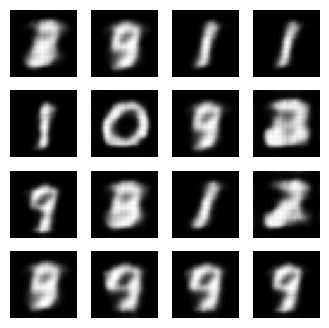

Epoch: 1, Test set variational lower bound: -170.70240783691406


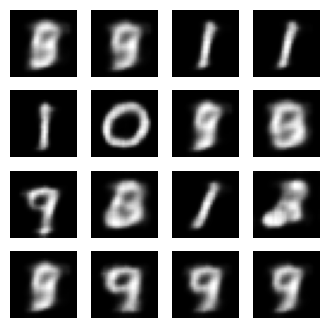

Epoch: 2, Test set variational lower bound: -166.6356201171875


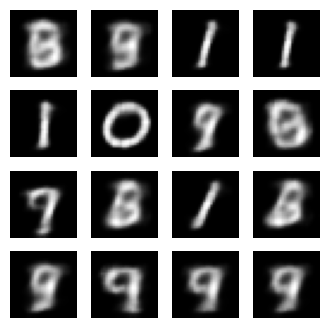

Epoch: 3, Test set variational lower bound: -164.09136962890625


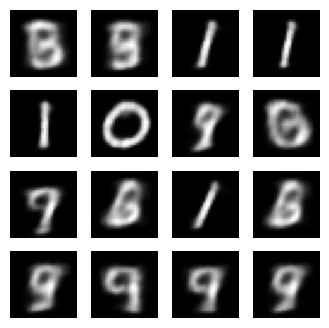

Epoch: 4, Test set variational lower bound: -162.3671112060547


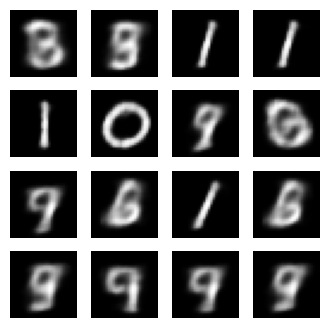

Epoch: 5, Test set variational lower bound: -160.6417694091797


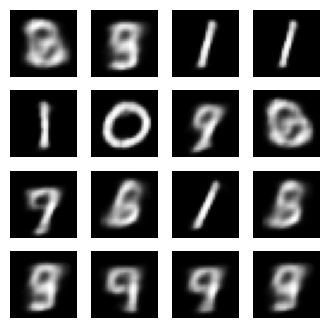

Epoch: 6, Test set variational lower bound: -159.5650177001953


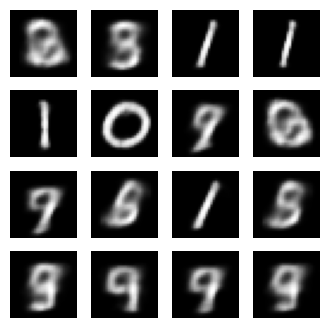

Epoch: 7, Test set variational lower bound: -158.67649841308594


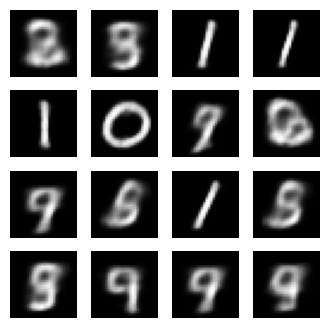

Epoch: 8, Test set variational lower bound: -157.90467834472656


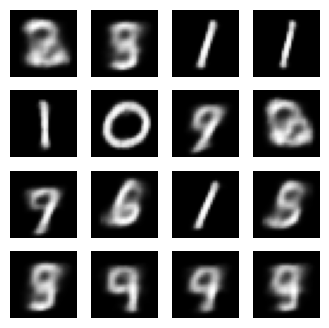

Epoch: 9, Test set variational lower bound: -157.41000366210938


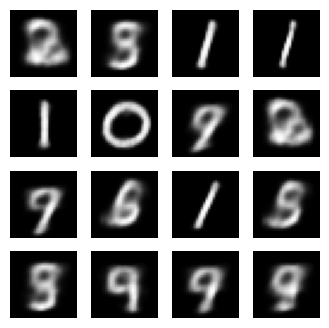

In [83]:
for epoch in range(10):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound:
           {variational_lower_bound}')
    generate_and_save_images(model, epoch, test_sample)

## 2D manifold

In [93]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    grid_y = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size, 
                  j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(7, 7))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

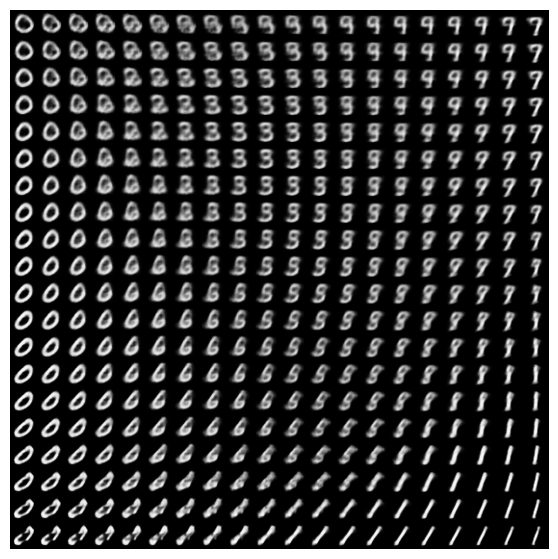

In [94]:
plot_latent_images(model, 20)

## Exercises

Use the Fashion MNIST data to solve this exercise. Load the images.

1. Use a VAE to learn a 2D variational representation of the images (i.e. 2 means and 2 standard deviations). Train your VAE. Plot the 2D latent space when you are done.
1. Try to use a VAE with a higher dimensional latent space (such as 5D instead of 2D). Does it achieve a better variational lower bound on the test images?

**Hint**: You may use the notebook I have uploaded under this lecture as a starting point (exercise-ae-vae.ipynb). It provides some of the code, and you then have to fill in the rest. You do not have to use it - it is there if you think it might be helpful!

## $\beta$-VAE

$\beta$-VAE, or *disentangled VAE*, are due to Higgins et al (2017).

It is a "generalization" of VAEs, where the regularization, i.e. the Kullback-Leibler divergence part of the lower bound, may be given additional weight.

Think of it this way: It is just a more strongly regularized version of a VAE. The regularization, however, has a very specific purpose: It is meant to make the generative process more disentangled, i.e. become more interpretable.

This happens by adding a single hyperparameter, $\beta$ - hence the name! It allows you to trade between reconstruction quality and disentanglement.

Why does giving the Kullback-Leibler divergence additional weight encourage disentanglement? It encourages conditional independence in $q_\phi(z|x)$.

**Note**: The next slide is more technical than most of this course. It is mainly here for those of you interested in working in more details in this topic (such as during your thesis, graduate work, or so forth).

## Derivation

Recall the lower bound: $\mathcal{L}(\theta,\phi;x)=\mathbb{E}_{q_\phi(z|x)}[log\,p_\theta(x|z)]-D_{KL}[q_{\phi}(z|x)||p_{\theta}(z)]$.

In some cases, we may be interested in imposing additional disentanglement over the generative process. We phrase this as a *constrained* optimization problem, i.e.
<br>
$\texttt{max}_{\phi,\theta}\,\mathbb{E}_{x\sim D}[\mathbb{E}_{q_\phi(z|x)}[log\,p_\theta(x|z)]]\,\,\,\texttt{subject to}\,D_{KL}[q_{\phi}(z|x)||p(z)]<\varepsilon^1$
<br>


Depending on your background, i.e. this may be familiar for economists, you may realize we can rewrite this Lagrangian under the Kuhn-Tucker-Karush conditions:
<br>
$\mathcal{F}(\theta,\phi,\beta;x,z)=\mathbb{E}_{q_\phi(z|x)}[log\,p_\theta(x|z)]-\beta[D_{KL}[q_{\phi}(z|x)||p(z)]-\varepsilon]$

Then, by complementary slackness,
<br>
$\mathcal{F}(\theta,\phi,\beta;x,z)\geq\mathcal{L}(\theta,\phi,\beta;x,z)=\mathbb{E}_{q_\phi(z|x)}[log\,p_\theta(x|z)]-\beta D_{KL}[q_{\phi}(z|x)||p(z)] $

Which is just a generalizartion, i.e. for $\beta=1$ this is "normal" VAE. For $\beta>1$, this imposes additional regularization/disentanglement.

$^1$**Note**: this $\varepsilon$ is some constant, **not** the one we used for sampling earlier! I use it instead of another letter to stay consistent with Higgins et al (2017).

## Comparing $\beta$-VAE to other generative algorithms

<img src="./graphics/higgins-et-al-17-fig-1.png" alt="Drawing" style="width: 1000px;"/>

Source: "Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., ... & Lerchner, A. (2016). beta-vae: Learning basic visual concepts with a constrained variational framework"

## Generative factors in $\beta$-VAE

<img src="./graphics/higgins-et-al-17-fig-4.png" alt="Drawing" style="width: 1000px;"/>

Source: "Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., ... & Lerchner, A. (2016). beta-vae: Learning basic visual concepts with a constrained variational framework"

## Advantages and disadvantages of autoencoders

Advantages
1. AEs are a way of learning latent representations of data in an unsupervised fashion by encoding and then decoding data. This is useful for tasks such as compression, anomaly detection, and image denoising.
1. By applying a variational Bayesian approach we arrive at VAEs, which learn the parameters of a statistical distribution. This improves robustness and forces the latent space to be meaningful everywhere. It also allows us to generate realistic, artificial data.
1. By changing the parameters of the distribution, we can change data in a deliberate way. $\beta$-VAE are particularly powerful at providing a meaningful, disentangled representation.

Disadvantages
1. Even though particularly $\beta$-VAE attempt to provide a disentangled representation, it is not possible to enforce specific types of disentanglement (that is, the factors may be disentangled, but it is not trivial to enforce a factor to encode a specific attribute).
1. In general, and particularly for non-variational AEs, understanding the latent space is difficult.

## Summary and looking ahead

In these lectures we have learned of AEs, including "classical" AEs for learning latent representations of data and of VAEs for learning parameters of a hidden statistical distribution.

This has allowed us to tackle issues such as compression, anomaly detection, image denoising, and artifical data generation - and much of this in an unsupervised fashion.

This leaves us with one topic left - *generative adversarial nets* (GANs). GANs are another way of generating artificial data, but is some ways much more extreme - the generator is now (in most cases) newer allowed to observe any real data, and has to learn only by feedback provided by a seperate network, the discriminator.

GANs are extremely cool, but also frustrating to use, as they are unstable to train. This is the result of simultaneously training 2 networks that train by competing in a zero-sum game.